# Chapter 9 - Partial Coherence Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, fft, ifft, ifftshift

# Define the rect function
def rect(x):
    return np.where(np.abs(x) <= 0.5, 1, 0)

def comb(x):
    # Dirac delta approximation: 1 where x is an integer, 0 otherwise
    return np.where(np.abs(x - np.round(x)) < 3e-2, 1, 0)

def circ_(x, y, r):
    return np.where(np.sqrt(x**2 + y**2) <= r, 1, 0)

def sinc(x):
    return np.where(x == 0, 1, np.sin(x) / x)

def triangle(x):
    return np.where(np.abs(x) <= 1, 1 - np.abs(x), 0)

def gauss(x):
    return np.exp(-x**2)

def circ(r):
    return lambda x, y: np.where(np.sqrt(x**2 + y**2) <= r, 1, 0)

def propTF(u1, L, lamda, z):
    M, N = np.shape(u1)
    dx = L / M
    k = 2 * np.pi / lamda

    fx = np.linspace(-M/(2*L), M/(2*L), M) ; fy = fx
    FX, FY = np.meshgrid(fx, fy)


    H = np.exp(-1j* np.pi * lamda * z * (FX **2 + FY **2))
    H = fftshift(H)
    U1 = fft2(fftshift(u1))
    U2 = H* U1
    u2 = ifftshift(ifft2(U2))
    return u2

def propIR(u1,L,lamda,z):
    M, N = np.shape(u1)
    dx = L / M
    k = 2 * np.pi / lamda

    x = np.linspace(-L/2, L/2, M) ; y = x
    X, Y = np.meshgrid(x, y)

    h = 1 / (1j * lamda * z) * np.exp(1j * k / (2 * z) * (X ** 2 + Y ** 2))
    H = fft2(fftshift(h)) * dx ** 2
    U1 = fft2(fftshift(u1))
    U2 = H*U1
    u2 = ifftshift(ifft2(U2))

    return u2

def propFF(u1, L1, lambda_, z):
    """
    Propagation - Fraunhofer pattern
    Assumes uniform sampling

    Parameters:
    u1 : ndarray - Source plane field
    L1 : float - Source plane side length
    lambda_ : float - Wavelength
    z : float - Propagation distance

    Returns:
    u2 : ndarray - Observation plane field
    L2 : float - Observation plane side length
    """
    M, N = u1.shape  # Get input field array size
    dx1 = L1 / M  # Source sample interval
    k = 2 * np.pi / lambda_  # Wavenumber

    L2 = lambda_ * z / dx1  # Observation side length
    dx2 = lambda_ * z / L1  # Observation sample interval
    x2 = np.arange(-L2 / 2, L2 / 2, dx2)  # Observation coordinates

    X2, Y2 = np.meshgrid(x2, x2)  # Create 2D grid of observation coordinates
    c = 1 / (1j * lambda_ * z) * np.exp(1j * k / (2 * z) * (X2**2 + Y2**2))
    u2 = c * np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(u1))) * dx1**2

    return u2, L2




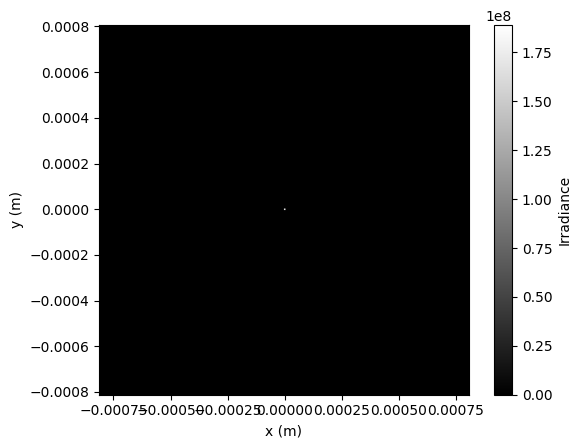

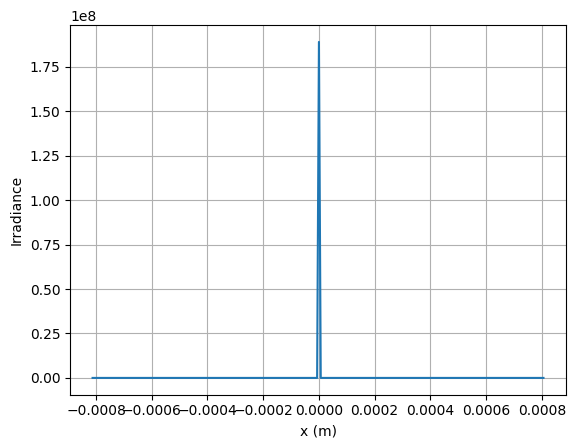

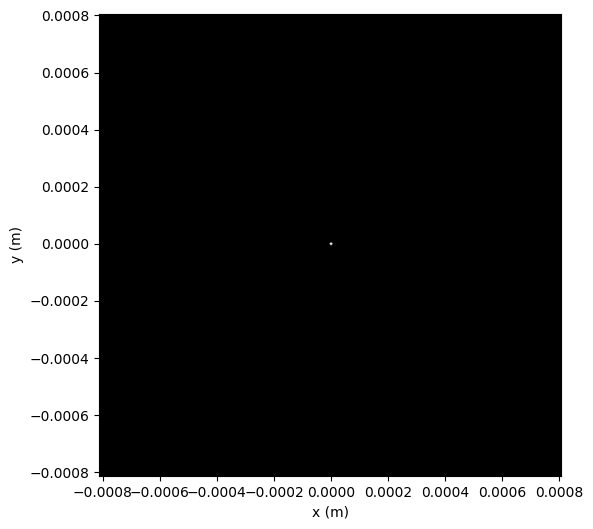

In [2]:
#################################################################

# 9.1.3 Partial temporal coherence example n

#################################################################

# pc_temp partial temporal coherence example

# Constants
lambda0 = 650e-9  # center wavelength (m)
c = 3e8  # speed of light (m/s)
k0 = 2 * np.pi / lambda0  # center wavenumber
nu0 = c / lambda0  # center frequency (Hz)

# Gaussian lineshape parameters
N = 51  # number of components (odd)
delnu = 2e9  # spectral density FWHM (Hz)
b = delnu / (2 * np.sqrt(np.log(2)))  # FWHM scaling
dnu = 4 * delnu / N  # frequency interval

# Source plane parameters
L1 = 50e-3  # source plane side length (m)
M = 250  # number of samples (even)
dx1 = L1 / M  # sample interval
x1 = np.linspace(-L1/2, L1/2 - dx1, M)  # source coordinates
x1 = np.fft.fftshift(x1)  # shift x coord
X1, Y1 = np.meshgrid(x1, x1)  # create grid

# Beam parameters
w = 1e-3  # radius of the beam
dels = 5e-3  # transverse separation (m)
deld = 5e-2  # delay distance (m)
f = 0.5  # focal distance for Fraunhofer diffraction
lf = lambda0 * f  # product for Fraunhofer pattern

# Initialize the irradiance array
I2 = np.zeros((M, M))


# Observation coordinates
x2 = np.linspace(-1/(2*dx1), 1/(2*dx1) - 1/L1, M) * lf
y2 = x2


# Loop through frequency components
for n in range(N):
    # Spectral density function
    nu = (n - (N + 1) / 2) * dnu + nu0
    S = 1 / (np.sqrt(np.pi) * b) * np.exp(-((nu - nu0) ** 2) / b ** 2)
    k = 2 * np.pi * nu / c

    # Source function
    u1 = circ(np.sqrt((X1 - dels / 2) ** 2 + Y1 ** 2) / w)(X1,Y1)
    u2 = circ(np.sqrt((X1 + dels / 2) ** 2 + Y1 ** 2) / w)(X1, Y1) * np.exp(1j * k * deld)
    u = u1 + u2

    # Fraunhofer pattern
    u2 = (1 / lf) * fft2(u) * dx1 ** 2

    # Weighted irradiance and summation
    I2 += S * (np.abs(u2) ** 2) * dnu
# Observation coordinates
x2 = np.linspace(-1/(2*dx1), 1/(2*dx1) - 1/L1, M) * lf
y2 = x2

# Normalize and center the irradiance pattern
I2 = ifftshift(I2)

# Plot irradiance image
plt.figure(1)
plt.imshow(I2, extent=(x2.min(), x2.max(), y2.min(), y2.max()), cmap='gray', aspect='equal', origin='lower')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.axis('square')
plt.colorbar(label='Irradiance')
plt.show()

# Plot irradiance profile
plt.figure(2)
plt.plot(x2, I2[M//2, :])  # Profile at the center row
plt.xlabel('x (m)')
plt.ylabel('Irradiance')
plt.grid(True)
plt.show()

# Plot irradiance image (like the left part of the image you uploaded)
plt.figure(figsize=(6,6))
plt.contourf(x2, y2, I2, levels=200, cmap='gray')  # Using contour plot for a similar look
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.axis('square')
plt.show()




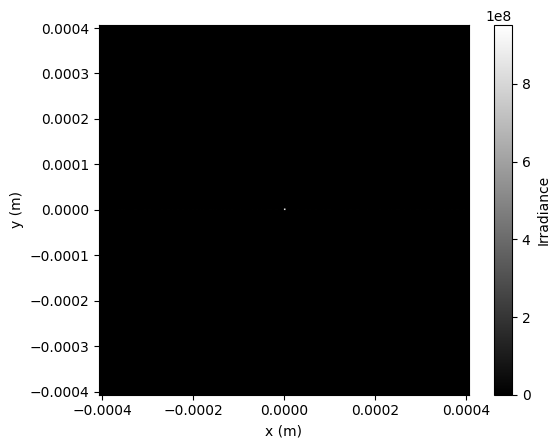

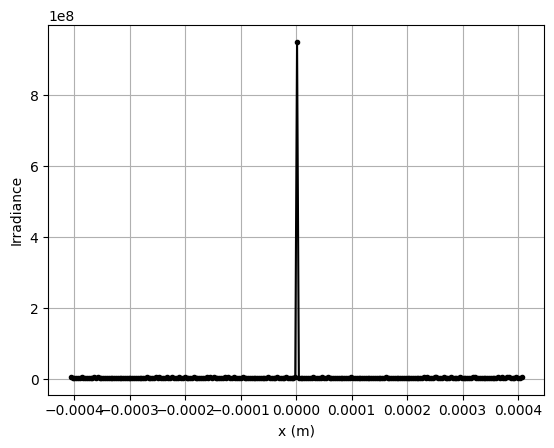

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifftshift, ifft2, fftshift

# Constants
lambda0 = 650e-9  # center wavelength (m)

# Source plane parameters
L1 = 50e-3  # source plane side length (m)
M = 250  # number of samples (even)
dx1 = L1 / M  # sample interval
x1 = np.linspace(-L1/2, L1/2 - dx1, M)  # source coordinates
x1 = np.fft.fftshift(x1)  # shift x coord
X1, Y1 = np.meshgrid(x1, x1)  # create grid

# Beam parameters
w = 1e-3  # radius of the beam
dels = 5e-3  # transverse separation (m)
deld = 5e-2  # delay distance (m)
f = 0.25  # focal distance for Fraunhofer diffraction
lf = lambda0 * f  # product for Fraunhofer pattern

N= 100
Lcr = 8e-2
sigma_f = 2.5*Lcr
sigma_r = np.sqrt((4*np.pi* sigma_f**4)/ (Lcr**2))

dfx1 = 1/L1
fx1 = np.linspace(-M/(2*L1), M/(2*L1), M)
fx1 = fftshift(fx1)
FX1, FY1 = np.meshgrid(fx1, fx1)



u1 = (circ(np.sqrt((X1 - dels / 2) ** 2 + Y1 ** 2) / w)(X1,Y1) +
      circ(np.sqrt((X1 + dels / 2) ** 2 + Y1 ** 2) / w)(X1, Y1))

F = np.exp(-np.pi**2 * sigma_f**2 * (FX1**2 + FY1**2))

I2 = np.zeros((M,M))

for n in range(N):
    fie = (ifft2(F* np.random.randn(M)) + 1j* np.random.randn(M) * sigma_r/dfx1) * M**2 * dfx1**2

    u2 = 1/lf * (fft2(u1* np.exp(1j* np.real(fie)))) * dx1**2

    I2 += np.abs(u2)**2

    u2 = 1/lf * (fft2(u1* np.exp(1j*np.imag(fie))))*dx1**2
    I2 += np.abs(u2)**2


I2 = ifftshift(I2) /N
x2 = np.linspace(-M/(2*L1),M/(2*L1), M)* lf
y2 = x2

# Plot irradiance image
plt.figure(1)
plt.imshow(I2, extent=(x2.min(), x2.max(), y2.min(), y2.max()), cmap='gray', aspect='equal', origin='lower')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.axis('square')
plt.colorbar(label='Irradiance')
plt.show()

# Plot irradiance profile
plt.figure(2)
plt.plot(x2, I2[M//2, :],"k.-")  # Profile at the center row
plt.xlabel('x (m)')
plt.ylabel('Irradiance')
plt.grid(True)
plt.show()

